In [12]:
### fetch_mldata('MNIST original')でRemoteDisconnectedエラーが出た場合

# https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat 
# ↑から mnist-original.mat をダウンロード

from sklearn.datasets.base import get_data_home 
print (get_data_home()) # これで表示されるパスに mnist-original.mat を置く

/home/naoko/scikit_learn_data


この画像データのラベルは5です


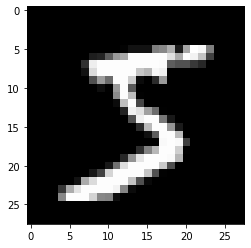

In [13]:
### fetch_mldata('MNIST original')でRemoteDisconnectedエラーのため書き換え
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original', data_home=".")  
# data_homeは保存するフォルダ
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1,)

# MNISTデータの前処理
# 28x28ピクセルごとの0-255の数値を0-1に変換
X = mnist.data / 255  
# 正解ラベルを取得
y = mnist.target

# MNISTのデータの1つ目をmatplotlib.pyplotで描画する
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("この画像データのラベルは{}です".format(y[0]))


In [198]:
# DataLoderの作成

import torch
from torch.utils.data import TensorDataset, DataLoader

# データを訓練とテストのために、6:1に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/7, random_state=0)

# 5-2. データのフォーマットを変換：PyTorchでの形式 = [画像数，チャネル数，高さ，幅]
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28 ,28)

y_train = y_train.astype("float64")
y_test = y_test.astype("float64")

# データをPyTorchのTensorに変換
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# データとラベルをセットにしたDatasetを作成
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# データセットのミニバッチサイズを指定した、Dataloaderを作成
# Chainerのiterators.SerialIteratorと似ている
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test,batch_size=64,  shuffle=False)


In [113]:
# ネットワークの構築
# Keras風の書き方 Define and Run

from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 100))
model.add_module('relu3', nn.ReLU())
model.add_module('fc4', nn.Linear(100, 100))
model.add_module('relu4', nn.ReLU())
model.add_module('fc5', nn.Linear(100, 100))
model.add_module('relu5', nn.ReLU())
model.add_module('fc6', nn.Linear(100, 10))

print(model)


Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=100, out_features=10, bias=True)
)


In [230]:
# 畳み込みニューラルネットワークの設定
import torch.nn as nn
import torch.nn.functional as F

num_layer = 2                   # 畳み込み層の数
num_filters = [16, 32]          # 各畳み込み層のフィルタ数
mid_units = 100                 # 全結合層のユニット数

in_height = 28
in_width = 28
kernel = 3
#dropout_prob = 0.0

class Net(nn.Module):
  def __init__(self, activation, dropout_prob):
    super(Net, self).__init__()
    self.activation = activation
    #self.activation = get_activation(trial)
    #self.activation = F.relu
    #第1層
    self.conv1 = nn.Conv2d(1, num_filters[0], 3)
    self.conv2 = nn.Conv2d(num_filters[0], num_filters[1], 3)

    #self.conv1_drop = nn.Dropout2d(p=dropout_prob)
    #self.conv2_drop = nn.Dropout2d(p=dropout_prob)
    #self.fc1_drop = nn.Dropout2d(p=dropout_prob)
    #self.fc2_drop = nn.Dropout2d(p=dropout_prob)
    
    self.fc1 = nn.Linear(in_features= 5*5*num_filters[1], out_features=mid_units) 
    self.fc2 = nn.Linear(in_features=mid_units, out_features=10)

  def forward(self, x):
    x = self.activation(F.max_pool2d(self.conv1(x), 2))
    #x = self.activation(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
    x = self.activation(F.max_pool2d(self.conv2(x), 2))
    #x = self.activation(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    
    x = x.view(x.size(0),-1)
    x = self.activation(self.fc1(x))
    #x = self.activation(self.fc1_drop(self.fc1(x)))
    #x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    #x = self.fc2_drop(self.fc2(x))
    return F.log_softmax(x, dim=1)

#model = Net(num_layer, mid_units, num_filters)
#print(model)

In [193]:
# 誤差関数と最適化手法の設定

from torch import optim

# 誤差関数の設定
loss_fn = nn.CrossEntropyLoss()  # 変数名にはcriterionも使われる

# 重みを学習する際の最適化手法の選択
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay = 0.001)

import torch.optim as optim

def get_optimizer(trial, model):
    optimizer_names = ['Adam', 'MomentumSGD']
    optimizer_name = trial.suggest_categorical('optimizer', optimizer_names)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-10, 1e-3)
    if optimizer_name == optimizer_names[0]: 
    # サンプルコードでは
    # if optimizer_name == 'Adam'
    # となっているが、地味にバグの元になりそうな気がした
        adam_lr = trial.suggest_loguniform('adam_lr', 1e-5, 1e-1)
        optimizer = optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
    else:
        momentum_sgd_lr = trial.suggest_loguniform('momentum_sgd_lr', 1e-5, 1e-1)
        optimizer = optim.SGD(model.parameters(), lr=momentum_sgd_lr,
                              momentum=0.9, weight_decay=weight_decay)
    return optimizer


In [195]:
# 活性化関数
def get_activation(trial):
    activation_names = ['ReLU', 'ELU']
    activation_name = trial.suggest_categorical('activation', activation_names)
    if activation_name == activation_names[0]:
        activation = F.relu
    else:
        activation = F.elu
    return activation

In [209]:
# 5. 学習と推論の設定
# 学習1回でやることを定義します
# Chainerのtraining.Trainer()に対応するものはない

from torch.autograd import Variable
  
def train(model, device, loader_train, optimizer):
    model.train()  # ネットワークを学習モードに切り替える

    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_train:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()  # 一度計算された勾配結果を0にリセット
        output = model(data)  # 入力dataをinputし、出力を求める
        loss = loss_fn(output, target)  # 出力と訓練データの正解との誤差を求める
        loss.backward()  # 誤差のバックプロパゲーションを求める
        optimizer.step()  # バックプロパゲーションの値で重みを更新する

    #print("epoch{}：終了\n".format(epoch))

# Chainerのtrainer.extend(extensions.Evaluator())に対応するものはない

def test(model, device, loader_test):
    model.eval()  # ネットワークを推論モードに切り替える
    correct = 0
 
    # データローダーから1ミニバッチずつ取り出して計算する
    for data, target in loader_test:
        data, target = data.to(device), target.to(device)
        output = model(data)  # 入力dataをinputし、出力を求める
        # 推論する
        pred = output.data.max(1, keepdim=True)[1]  # 出力ラベルを求める
        correct += pred.eq(target.data.view_as(pred)).sum().item()  # 正解と一緒だったらカウントアップ
 
    # 正解率を出力
    data_num = len(loader_test.dataset)  # データの総数
    #print('\nテストデータの正解率: {}/{} ({:.0f}%)\n'.format(correct,
    #                                              data_num, 100. * correct / data_num))
    return 1 - correct / data_num

In [178]:
# 学習なしにテストデータで推論
test()



テストデータの正解率: 1064/10000 (10%)



In [191]:
# 60000のデータに3エポック学習を実行する
for epoch in range(3):
    train(epoch)
 
test()


epoch0：終了

epoch1：終了

epoch2：終了


テストデータの正解率: 9231/10000 (92%)



In [211]:
# Dropoutあり

import optuna

EPOCH = 3

def objective(trial):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    activation = get_activation(trial)
    dropout_prob = trial.suggest_uniform("dropout_prob", 0, 0.8)

    model = Net(activation, dropout_prob).to(device)
    optimizer = get_optimizer(trial, model)

    for step in range(EPOCH):
        train(model, device, loader_train, optimizer)
        error_rate = test(model, device, loader_test)

    return error_rate

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2019-08-07 15:23:39,011] Finished trial#0 resulted in value: 0.12629999999999997. Current best value is 0.12629999999999997 with parameters: {'activation': 'ELU', 'dropout_prob': 0.37433377049639943, 'optimizer': 'Adam', 'weight_decay': 5.591573802238303e-09, 'adam_lr': 1.5340032406828095e-05}.
[I 2019-08-07 15:25:48,191] Finished trial#1 resulted in value: 0.128. Current best value is 0.12629999999999997 with parameters: {'activation': 'ELU', 'dropout_prob': 0.37433377049639943, 'optimizer': 'Adam', 'weight_decay': 5.591573802238303e-09, 'adam_lr': 1.5340032406828095e-05}.
[I 2019-08-07 15:27:55,066] Finished trial#2 resulted in value: 0.04949999999999999. Current best value is 0.04949999999999999 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.060369451962114344, 'optimizer': 'Adam', 'weight_decay': 3.1707146143075956e-08, 'adam_lr': 8.243044009824591e-05}.
[I 2019-08-07 15:31:43,990] Finished trial#3 resulted in value: 0.9011. Current best value is 0.04949999999999999 w

[I 2019-08-07 16:41:40,061] Finished trial#26 resulted in value: 0.015599999999999947. Current best value is 0.014900000000000024 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.6231808687487563, 'optimizer': 'Adam', 'weight_decay': 3.132147015200396e-05, 'adam_lr': 0.0020962014478128426}.
[I 2019-08-07 16:44:49,907] Finished trial#27 resulted in value: 0.015199999999999991. Current best value is 0.014900000000000024 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.6231808687487563, 'optimizer': 'Adam', 'weight_decay': 3.132147015200396e-05, 'adam_lr': 0.0020962014478128426}.
[I 2019-08-07 16:47:08,311] Finished trial#28 resulted in value: 0.031399999999999983. Current best value is 0.014900000000000024 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.6231808687487563, 'optimizer': 'Adam', 'weight_decay': 3.132147015200396e-05, 'adam_lr': 0.0020962014478128426}.
[I 2019-08-07 16:49:29,112] Finished trial#29 resulted in value: 0.10450000000000004. Current bes

[I 2019-08-07 17:50:17,788] Finished trial#53 resulted in value: 0.013900000000000023. Current best value is 0.013399999999999967 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.47847311701491446, 'optimizer': 'Adam', 'weight_decay': 6.078259066703996e-08, 'adam_lr': 0.0026697163352142213}.
[I 2019-08-07 17:52:24,292] Finished trial#54 resulted in value: 0.017299999999999982. Current best value is 0.013399999999999967 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.47847311701491446, 'optimizer': 'Adam', 'weight_decay': 6.078259066703996e-08, 'adam_lr': 0.0026697163352142213}.
[I 2019-08-07 17:54:29,050] Finished trial#55 resulted in value: 0.019299999999999984. Current best value is 0.013399999999999967 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.47847311701491446, 'optimizer': 'Adam', 'weight_decay': 6.078259066703996e-08, 'adam_lr': 0.0026697163352142213}.
[I 2019-08-07 17:56:30,347] Finished trial#56 resulted in value: 0.01739999999999997. Current 

[I 2019-08-07 18:49:44,499] Finished trial#80 resulted in value: 0.01639999999999997. Current best value is 0.012900000000000023 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5453655204393352, 'optimizer': 'Adam', 'weight_decay': 1.1930892632063503e-07, 'adam_lr': 0.0025745108772260075}.
[I 2019-08-07 18:51:49,287] Finished trial#81 resulted in value: 0.013499999999999956. Current best value is 0.012900000000000023 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5453655204393352, 'optimizer': 'Adam', 'weight_decay': 1.1930892632063503e-07, 'adam_lr': 0.0025745108772260075}.
[I 2019-08-07 18:54:26,408] Finished trial#82 resulted in value: 0.021199999999999997. Current best value is 0.012900000000000023 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5453655204393352, 'optimizer': 'Adam', 'weight_decay': 1.1930892632063503e-07, 'adam_lr': 0.0025745108772260075}.
[I 2019-08-07 18:56:33,250] Finished trial#83 resulted in value: 0.015000000000000013. Current 

In [212]:
study.best_params

{'activation': 'ReLU',
 'dropout_prob': 0.021829776206425844,
 'optimizer': 'Adam',
 'weight_decay': 2.369490691276072e-07,
 'adam_lr': 0.0018922939418576164}

In [218]:
study.bestvalue

0.011900000000000022

In [231]:
# Dropoutなし

import optuna

EPOCH = 3

def objective(trial):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    activation = get_activation(trial)
    dropout_prob = trial.suggest_uniform("dropout_prob", 0, 0.8)

    model = Net(activation, dropout_prob).to(device)
    optimizer = get_optimizer(trial, model)

    for step in range(EPOCH):
        train(model, device, loader_train, optimizer)
        error_rate = test(model, device, loader_test)

    return error_rate

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2019-08-08 19:22:41,026] Finished trial#0 resulted in value: 0.4496. Current best value is 0.4496 with parameters: {'activation': 'ELU', 'dropout_prob': 0.46082507985960214, 'optimizer': 'MomentumSGD', 'weight_decay': 1.1965217278858144e-09, 'momentum_sgd_lr': 5.0577210952985414e-05}.
[I 2019-08-08 19:26:45,753] Finished trial#1 resulted in value: 0.013800000000000034. Current best value is 0.013800000000000034 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.7533446029561262, 'optimizer': 'MomentumSGD', 'weight_decay': 1.817300549931962e-07, 'momentum_sgd_lr': 0.016741120545311707}.
[I 2019-08-08 19:30:32,132] Finished trial#2 resulted in value: 0.03469999999999995. Current best value is 0.013800000000000034 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.7533446029561262, 'optimizer': 'MomentumSGD', 'weight_decay': 1.817300549931962e-07, 'momentum_sgd_lr': 0.016741120545311707}.
[I 2019-08-08 19:32:41,745] Finished trial#3 resulted in value: 0.020499999999999963

[I 2019-08-08 20:22:30,835] Finished trial#26 resulted in value: 0.017100000000000004. Current best value is 0.012800000000000034 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.6834379356234838, 'optimizer': 'MomentumSGD', 'weight_decay': 1.1871346257175986e-07, 'momentum_sgd_lr': 0.05120864632122043}.
[I 2019-08-08 20:24:31,397] Finished trial#27 resulted in value: 0.021199999999999997. Current best value is 0.012800000000000034 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.6834379356234838, 'optimizer': 'MomentumSGD', 'weight_decay': 1.1871346257175986e-07, 'momentum_sgd_lr': 0.05120864632122043}.
[I 2019-08-08 20:26:23,645] Finished trial#28 resulted in value: 0.03210000000000002. Current best value is 0.012800000000000034 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.6834379356234838, 'optimizer': 'MomentumSGD', 'weight_decay': 1.1871346257175986e-07, 'momentum_sgd_lr': 0.05120864632122043}.
[I 2019-08-08 20:28:17,440] Finished trial#29 resulted i

[I 2019-08-08 21:20:38,137] Finished trial#53 resulted in value: 0.07940000000000003. Current best value is 0.0121 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5168976444455581, 'optimizer': 'MomentumSGD', 'weight_decay': 1.2038583827966751e-07, 'momentum_sgd_lr': 0.03736188443318031}.
[I 2019-08-08 21:23:09,384] Finished trial#54 resulted in value: 0.8987. Current best value is 0.0121 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5168976444455581, 'optimizer': 'MomentumSGD', 'weight_decay': 1.2038583827966751e-07, 'momentum_sgd_lr': 0.03736188443318031}.
[I 2019-08-08 21:25:35,859] Finished trial#55 resulted in value: 0.012700000000000045. Current best value is 0.0121 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5168976444455581, 'optimizer': 'MomentumSGD', 'weight_decay': 1.2038583827966751e-07, 'momentum_sgd_lr': 0.03736188443318031}.
[I 2019-08-08 21:28:00,571] Finished trial#56 resulted in value: 0.015599999999999947. Current best value is 0.0

[I 2019-08-08 22:20:01,370] Finished trial#80 resulted in value: 0.011900000000000022. Current best value is 0.010600000000000054 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5993657899247533, 'optimizer': 'MomentumSGD', 'weight_decay': 2.940744863502711e-07, 'momentum_sgd_lr': 0.048160721856100486}.
[I 2019-08-08 22:22:06,153] Finished trial#81 resulted in value: 0.015800000000000036. Current best value is 0.010600000000000054 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5993657899247533, 'optimizer': 'MomentumSGD', 'weight_decay': 2.940744863502711e-07, 'momentum_sgd_lr': 0.048160721856100486}.
[I 2019-08-08 22:24:37,145] Finished trial#82 resulted in value: 0.8859. Current best value is 0.010600000000000054 with parameters: {'activation': 'ReLU', 'dropout_prob': 0.5993657899247533, 'optimizer': 'MomentumSGD', 'weight_decay': 2.940744863502711e-07, 'momentum_sgd_lr': 0.048160721856100486}.
[I 2019-08-08 22:26:59,633] Finished trial#83 resulted in value: 0.03

In [232]:
study.best_params

{'activation': 'ReLU',
 'dropout_prob': 0.5993657899247533,
 'optimizer': 'MomentumSGD',
 'weight_decay': 2.940744863502711e-07,
 'momentum_sgd_lr': 0.048160721856100486}

In [237]:
study.best_value
1-0.0106

0.9894